<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Overview" data-toc-modified-id="Overview-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Overview</a></span></li><li><span><a href="#-Load-Data" data-toc-modified-id="-Load-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span> Load Data</a></span></li><li><span><a href="#Transform-for-Survival-Analysis" data-toc-modified-id="Transform-for-Survival-Analysis-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Transform for Survival Analysis</a></span><ul class="toc-item"><li><span><a href="#Transform-Business-Code" data-toc-modified-id="Transform-Business-Code-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Transform Business Code</a></span></li></ul></li><li><span><a href="#Kaplan-Meier-Survival-Analysis-" data-toc-modified-id="Kaplan-Meier-Survival-Analysis--4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Kaplan-Meier Survival Analysis </a></span></li><li><span><a href="#-Cox-Proportional-Hazard-Model-" data-toc-modified-id="-Cox-Proportional-Hazard-Model--5"><span class="toc-item-num">5&nbsp;&nbsp;</span> Cox Proportional Hazard Model </a></span></li><li><span><a href="#Conclusions-and-Next-Steps" data-toc-modified-id="Conclusions-and-Next-Steps-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Conclusions and Next Steps</a></span></li></ul></div>

<h3>Overview

In this notebook we continue to apply survival analysis to predict the lifetime of a business based on the characteristics of a neighborhood.  Here we use the a subset of the business data representing businesses that have opened in 2000 or later, to which we have added additional features. This dataset contains additional features for which we want to explore the predictive value, and therefore this notebook will focus more on the survival regression with Cox PHC than the Kaplan-Meyer estimator. 

Survival analysis is also called 'time to event' analysis

Here use the Lifelines library, which is:

-  Built on top of Pandas 
-  Internal plotting methods 
-  Simple and intuitive API 
-  Only focus is survival analysis

We use two models from this library this project
-  Kaplan-Meier - Estimating survival rates for specific populations
-  Cox Proportional Hazards Model - Survival Regression

What we are looking at is time-to-event data in the presence of censoring
- takes time into account (duration, or lifetime, from a given start time to an specified event) In this case it is the time from when a business opens to when it closes.
- differentiates between full information (business has closed prior to the time of interest and we know when it was closed, therefore have complete information about the duration)and censored information (the business is still open. The duration is the time since it opened until the present, but that is not complete information. This is a type of missing data.)

Survival Regression - Accounting for multiple predictor variables in estimating survival times
-  Can't use ordinary linear regression - You would either have to drop the censored subjects as missing data, or underestimate the duration
-  Can't use logistic regression because it can't take into account the time component
-  Can't use time series analysis because you are dealing with different start dates and durations, not calendar time

In [1]:
import os
import sys
import re
import time
import datetime

import pickle

module_path = os.path.abspath(os.path.join('./lib/'))

if module_path not in sys.path:   
    sys.path.append(module_path)
from utilities import *

import geopandas as gpd
from geopandas.tools import geocode
from shapely.geometry import Point

import pandas as pd
import numpy as np
import numpy
import seaborn as sns

from lifelines.datasets import load_rossi
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import logrank_test
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from lifelines.plotting import plot_lifetimes
from numpy.random import uniform, exponential

import matplotlib.pyplot as plt
%matplotlib inline 

<h3> Load Data

In [2]:
df = pd.read_csv('../tmp/recent_bus_with_features_20190514.csv', low_memory = False)


In [3]:
df.shape

(168692, 42)

<h3>Transform for Survival Analysis

This file contains additional transformations done for survival analysis. The original dataset remains the same for future additional types of modeling, as well as iterative data exploration, to help explain model results.

<h4>Transform Business Code

Business type is represented in the naic_code and naic_description fields. 
https://www.census.gov/eos/www/naics/

In [4]:
#extract primary (first listed) business code
naic = df['naic_code'].str.split('-', n=1, expand=True)
df['naic'] = naic[0]
df.head()

,zip,certificate_number,city,dba_name,full_business_address,lic,lic_code_description,location,mail_city,mail_state,...,dur,status,new_neighborhood,neighborhood_size,size_rank,bus_opened,bus_closed,evictions,med_pr_sqft,naic
0,94133.0,86,San Francisco,1601 Grant Parking,1601 Grant Ave,.,.,"{'latitude': '37.801724', 'longitude': '-122.4...",NaN,NaN,...,13,closed,North Beach,Medium,5770,89,15,18,755,.
1,94118.0,189,San Francisco,Abbey Carpet,2900 Geary Blvd,.,.,"{'latitude': '37.782133', 'longitude': '-122.4...",San Francisco,CA,...,27,open,Presidio Heights,Medium,3259,36,6,4,970,4400
2,94118.0,189,San Francisco,Abbey Carpet Of San Francisco,2900 Geary Blvd,.,.,"{'latitude': '37.782133', 'longitude': '-122.4...",San Francisco,CA,...,22,open,Presidio Heights,Medium,3259,35,39,4,1088,4400
3,94124.0,216,San Francisco,Abc Insurance,1727 Oakdale Ave,.,.,"{'latitude': '37.736139', 'longitude': '-122.3...",NaN,NaN,...,62,closed,Bayview Hunters Point,Medium,0,28,0,11,0,.
4,94107.0,244,San Francisco,Able Services,868 Folsom St,.,.,"{'latitude': '37.780746', 'longitude': '-122.4...",San Francisco,CA,...,56,open,South of Market,Dense,498,45,2,24,668,5600


Extract the first four characters of naic code. This represents the business type, and can be used for stratification. In future iterations with more time for data cleaning this can be combined with license codes to study businesses types at a more granular data. Licene type is missing even more data, though, so some careful thought will have to go into what can be dropped and what means for the final dataset and any future analysis.

In [5]:
df[['naic_code', 'naic', 'naic_code_description']].head()

,naic_code,naic,naic_code_description
0,.,.,.
1,4400-4599,4400,Retail Trade
2,4400-4599,4400,Retail Trade
3,.,.,.
4,5600-5699,5600,Administrative and Support Services


In [6]:
df[['naic_code', 'naic', 'naic_code_description']].tail()

,naic_code,naic,naic_code_description
168687,.,.,.
168688,5300-5399,5300,Real Estate and Rental and Leasing Services
168689,5210-5239,5210,Financial Services
168690,5210-5239,5210,Financial Services
168691,4800-4999,4800,Transportation and Warehousing


In [7]:
df.head()

,zip,certificate_number,city,dba_name,full_business_address,lic,lic_code_description,location,mail_city,mail_state,...,dur,status,new_neighborhood,neighborhood_size,size_rank,bus_opened,bus_closed,evictions,med_pr_sqft,naic
0,94133.0,86,San Francisco,1601 Grant Parking,1601 Grant Ave,.,.,"{'latitude': '37.801724', 'longitude': '-122.4...",NaN,NaN,...,13,closed,North Beach,Medium,5770,89,15,18,755,.
1,94118.0,189,San Francisco,Abbey Carpet,2900 Geary Blvd,.,.,"{'latitude': '37.782133', 'longitude': '-122.4...",San Francisco,CA,...,27,open,Presidio Heights,Medium,3259,36,6,4,970,4400
2,94118.0,189,San Francisco,Abbey Carpet Of San Francisco,2900 Geary Blvd,.,.,"{'latitude': '37.782133', 'longitude': '-122.4...",San Francisco,CA,...,22,open,Presidio Heights,Medium,3259,35,39,4,1088,4400
3,94124.0,216,San Francisco,Abc Insurance,1727 Oakdale Ave,.,.,"{'latitude': '37.736139', 'longitude': '-122.3...",NaN,NaN,...,62,closed,Bayview Hunters Point,Medium,0,28,0,11,0,.
4,94107.0,244,San Francisco,Able Services,868 Folsom St,.,.,"{'latitude': '37.780746', 'longitude': '-122.4...",San Francisco,CA,...,56,open,South of Market,Dense,498,45,2,24,668,5600


In [8]:
dfclosed = df[df.status == 'closed']
dfclosed.head()

,zip,certificate_number,city,dba_name,full_business_address,lic,lic_code_description,location,mail_city,mail_state,...,dur,status,new_neighborhood,neighborhood_size,size_rank,bus_opened,bus_closed,evictions,med_pr_sqft,naic
0,94133.0,86,San Francisco,1601 Grant Parking,1601 Grant Ave,.,.,"{'latitude': '37.801724', 'longitude': '-122.4...",NaN,NaN,...,13,closed,North Beach,Medium,5770,89,15,18,755,.
3,94124.0,216,San Francisco,Abc Insurance,1727 Oakdale Ave,.,.,"{'latitude': '37.736139', 'longitude': '-122.3...",NaN,NaN,...,62,closed,Bayview Hunters Point,Medium,0,28,0,11,0,.
16,94105.0,265,San Francisco,Academy Of Art University,631 Howard St,.,.,"{'latitude': '37.786347', 'longitude': '-122.3...",San Francisco,CA,...,10,closed,Financial District/South Beach,Dense,0,483,46,0,0,6100
23,94111.0,368,San Francisco,Acoustical Consultants Inc,150 California St 3rd Flr,.,.,"{'latitude': '37.793407', 'longitude': '-122.3...",NaN,NaN,...,55,closed,Financial District/South Beach,Dense,0,124,0,4,0,.
24,94103.0,422,San Francisco,Adler Kurt S Inc,680 Eighth Street 157,.,.,"{'latitude': '37.770475', 'longitude': '-122.4...",NaN,NaN,...,26,closed,South of Market,Dense,498,240,33,8,584,4200


Validate that the date ranges is as expected. In this analysis the data is limited to businesses that started in the year 2000 or later. This was because the features added to the set were available for this time frame.

In [9]:
df.y_start.describe()

count    168692.000000
mean       2011.987279
std           4.569724
min        2000.000000
25%        2009.000000
50%        2013.000000
75%        2016.000000
max        2018.000000
Name: y_start, dtype: float64

In [10]:
df.y_end.describe()

count    168692.000000
mean       6338.154566
std        3977.831024
min        2000.000000
25%        2017.000000
50%        9999.000000
75%        9999.000000
max        9999.000000
Name: y_end, dtype: float64

I again calculate the duration. This should be encapsulated in a single place. As part of clean up, or in a future iteration of this project, I will move it into a utility file.

In [11]:
df['y_end'] = df.apply(lambda row: 0 if row.y_end == 9999 else row.y_end, axis=1)

In [12]:
df[['y_start', 'y_end']].head(10)

,y_start,y_end
0,2013,2016
1,2012,0
2,2013,0
3,2002,2018
4,2005,0
5,2004,0
6,2009,0
7,2009,0
8,2005,0
9,2011,0


In [13]:
#calculate how long a business has been open in quarters
def calc_duration(ys,qs,ye,qe):
    if ye==0:
        ye=2019
        qe=2
    d =(ye-ys)*4
    d += (qe-qs)
    if d < 0:
        d = abs(d)
    return int(d)

In [14]:
#calculate how long a business has been open in years
def calc_lifetime(ys,ye):
    if ye==0:
        ye=2019
    lifetime = (ye-ys)
    if lifetime < 0:
        print (f'ALERT***** BAD DATA  ys: {ys}, ye: {ye}, returning: {lifetime}')

    return int(lifetime)

In [15]:
df['lifetime'] = df.apply(lambda row: calc_lifetime(row.y_start,
                                           row.y_end),
                       axis=1)

In [16]:
df['lifetime_qtrs'] = df.apply(lambda row: calc_duration(row.y_start,
                                          row.q_start,
                                          row.y_end,
                                          row.q_end),
                       axis=1)

In [17]:
df[['lifetime', 'lifetime_qtrs', 'y_start', 'y_end', 'q_start', 'q_end']].head()

,lifetime,lifetime_qtrs,y_start,y_end,q_start,q_end
0,3,13,2013,2016,1,2.0
1,7,27,2012,0,3,0.0
2,6,22,2013,0,4,0.0
3,16,62,2002,2018,4,2.0
4,14,56,2005,0,2,0.0


In [18]:
df['lifetime'].describe()

count    168692.000000
mean          5.598914
std           4.586002
min           0.000000
25%           2.000000
50%           4.000000
75%           8.000000
max          19.000000
Name: lifetime, dtype: float64

In [19]:
df['lifetime_qtrs'].describe()

count    168692.000000
mean         22.275721
std          18.328804
min           0.000000
25%           7.000000
50%          17.000000
75%          33.000000
max          77.000000
Name: lifetime_qtrs, dtype: float64

Use box plots to identify the degree to which there are outliers in terms of lifetime, and to compare the lifetime spread for the different features.

In [20]:
sns.set_context('poster')
sns.set(style="ticks", palette="pastel")

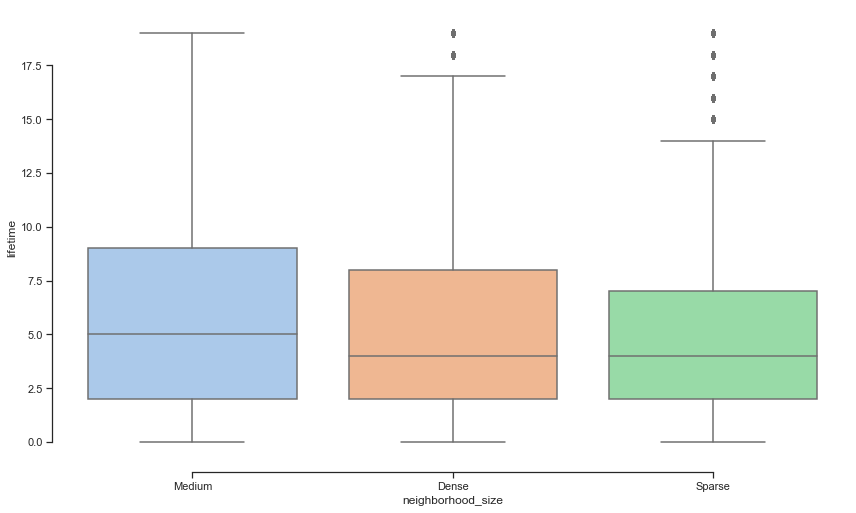

In [21]:
fig, ax = plt.subplots()
fig.set_size_inches(14, 8.27)


sns.boxplot(x='neighborhood_size', y='lifetime',
            data=df)
sns.despine(offset=10, trim=True);

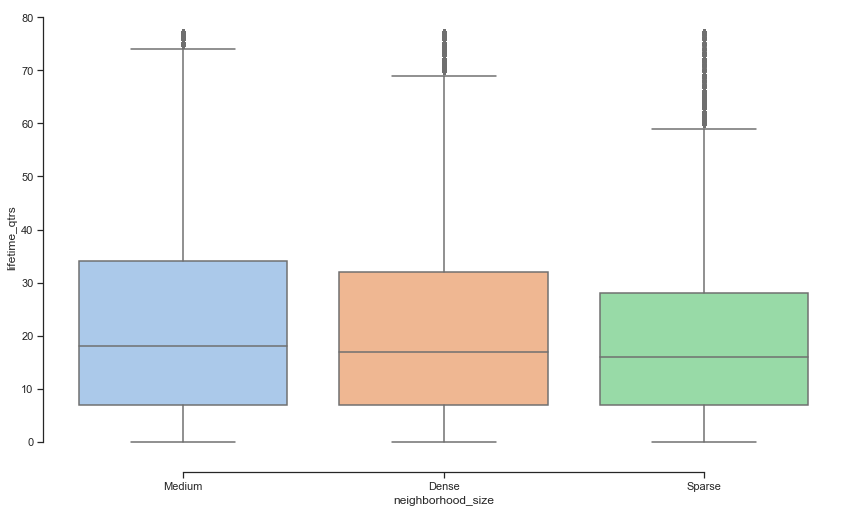

In [22]:
fig, ax = plt.subplots()
fig.set_size_inches(14, 8.27)
sns.boxplot(x='neighborhood_size', y='lifetime_qtrs',
            data=df);
sns.despine(offset=10, trim=True);

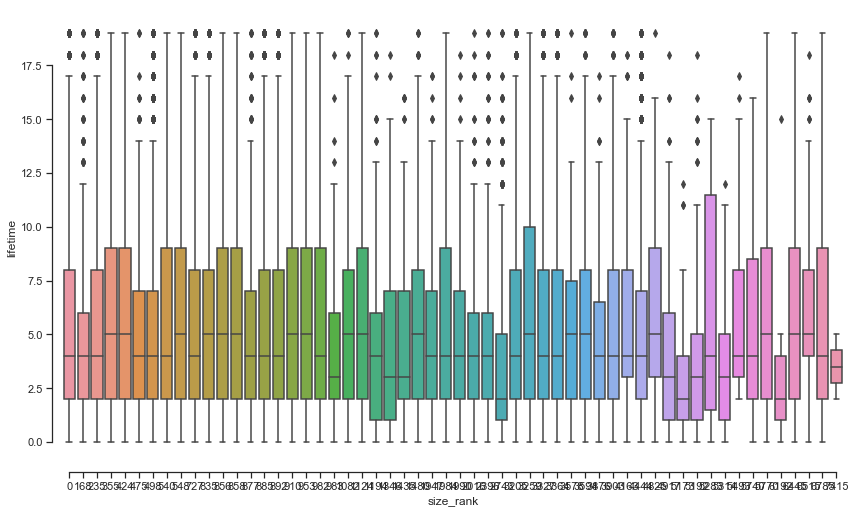

In [23]:
fig, ax = plt.subplots()
fig.set_size_inches(14, 8.27)
sns.boxplot(x='size_rank', y='lifetime',
            data=df);

sns.despine(offset=10, trim=True);

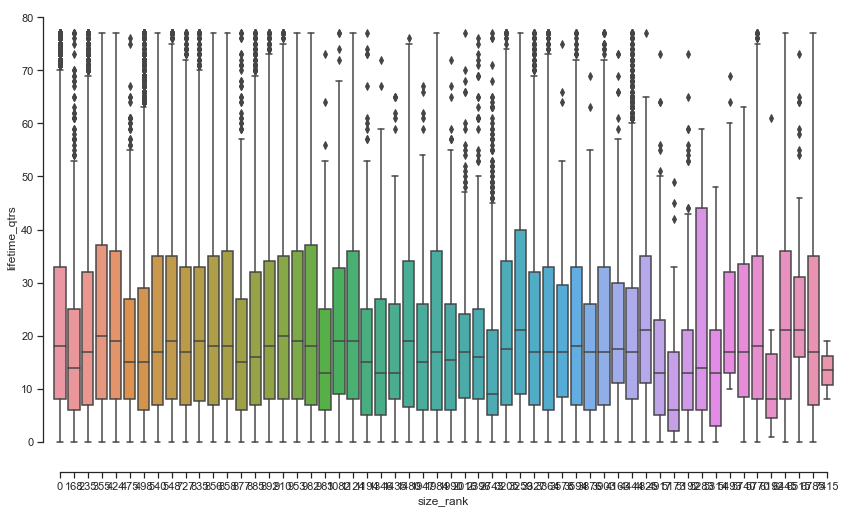

In [24]:
fig, ax = plt.subplots()
fig.set_size_inches(14, 8.27)
sns.boxplot(x='size_rank', y='lifetime_qtrs',
            data=df);
sns.despine(offset=10, trim=True);

There does seem to be some variation in the lifetime values for both the zillow calculated size rank and the categorical values for density I calculated.

In [25]:
df['observed'] = df.apply(lambda row: 0 if row.status == 'open' else 1, axis=1)

In [26]:
#save again
df.to_csv('../tmp/recent_bus_modeling_stg1_asof20190515.csv', index=False)

In [27]:
df = pd.read_csv('../tmp/recent_bus_modeling_stg1_asof20190515.csv', low_memory = False)

Take a look at the colums that will be used for the analysis

In [28]:
df[['lifetime', 'lifetime_qtrs', 'observed', 'status', 'y_start', 'y_end', 'q_start', 'q_end']].head(20)

,lifetime,lifetime_qtrs,observed,status,y_start,y_end,q_start,q_end
0,3,13,1,closed,2013,2016,1,2.0
1,7,27,0,open,2012,0,3,0.0
2,6,22,0,open,2013,0,4,0.0
3,16,62,1,closed,2002,2018,4,2.0
4,14,56,0,open,2005,0,2,0.0
5,15,61,0,open,2004,0,1,0.0
6,10,40,0,open,2009,0,2,0.0
7,10,38,0,open,2009,0,4,0.0
8,14,55,0,open,2005,0,3,0.0
9,8,33,0,open,2011,0,1,0.0


<h3>Kaplan-Meier Survival Analysis 

This notebook doesn't focus much on Kaplan-Meier Survival Analysis. This is because it did not provide any additional insight over the analysis done in notebook 3.1, and in most cases the results were less intersting. Here we just fit and plot the survival curve for all businesses. One interesting thing is that the median survival rate for the businesses that opened within the past 20 years is 9 years, whereas all the businesses for the last 200 years have a median of 12. If (and this is a big if) we had complete data for the full history of the 200 years we would probably see a very different story. In fact, 50th percentile start year for this data is 2013, and 2012 for the entire dataset!

In [29]:
df.y_start.describe()

count    168692.000000
mean       2011.987279
std           4.569724
min        2000.000000
25%        2009.000000
50%        2013.000000
75%        2016.000000
max        2018.000000
Name: y_start, dtype: float64

In [30]:
#set parameters for km
T = df['lifetime']
TQ = df['lifetime_qtrs']
E = df['observed']

Median lifetime in years = 9.0


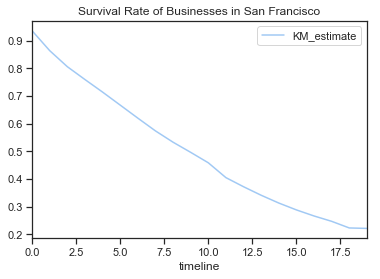

In [31]:
#fit based on years
kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E)

print(f'Median lifetime in years = {kmf.median_}')
kmf.survival_function_.plot()

plt.title(f'Survival Rate of Businesses in San Francisco');

Median lifetime in quarters = 36.0


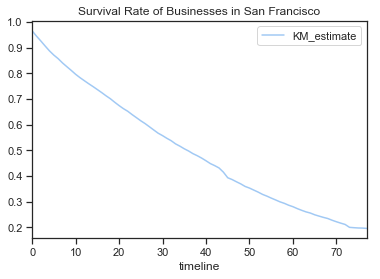

In [32]:
#fit based on quarters
kmf = KaplanMeierFitter()
kmf.fit(TQ, event_observed=E)
print(f'Median lifetime in quarters = {kmf.median_}')
kmf.survival_function_.plot()
plt.title(f'Survival Rate of Businesses in San Francisco');


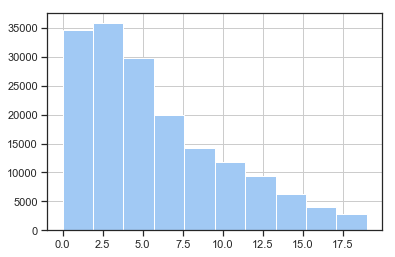

In [33]:
T.hist()

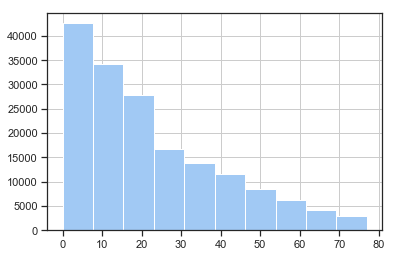

In [34]:
TQ.hist()

<h3> Cox Proportional Hazard Model 

As explained above, Kaplan-Meier did not provide any additional insight over the analysis done in notebook 3.1, and in most cases was less intersting. The rest of this notebook focuses survival with regression using the Cox PHC model. Adding features to the dataset to attempt to build a predictive model is the main purpose of this notebook. 
<br><br>
Additional features include:  
-  bus_opened - Number of businesses that opened in a given neighborhood during the start quarter
-  bus_closed - Number of businesses that closed in a given neighborhood during the start quarter
-  evictions - Number of eviction notices filed for a given neighborhood during the start quarter
-  med_pr_sqft - Median home price for a given neighborhood during the start quarter, from Zillow

In [35]:
df['category'] = df.apply(lambda row: 1 if row.neighborhood_size == 'Sparse' else
                               (2 if row.neighborhood_size == 'Medium' else 3), axis=1)
df.head()

,zip,certificate_number,city,dba_name,full_business_address,lic,lic_code_description,location,mail_city,mail_state,...,size_rank,bus_opened,bus_closed,evictions,med_pr_sqft,naic,lifetime,lifetime_qtrs,observed,category
0,94133.0,86,San Francisco,1601 Grant Parking,1601 Grant Ave,.,.,"{'latitude': '37.801724', 'longitude': '-122.4...",NaN,NaN,...,5770,89,15,18,755,.,3,13,1,2
1,94118.0,189,San Francisco,Abbey Carpet,2900 Geary Blvd,.,.,"{'latitude': '37.782133', 'longitude': '-122.4...",San Francisco,CA,...,3259,36,6,4,970,4400,7,27,0,2
2,94118.0,189,San Francisco,Abbey Carpet Of San Francisco,2900 Geary Blvd,.,.,"{'latitude': '37.782133', 'longitude': '-122.4...",San Francisco,CA,...,3259,35,39,4,1088,4400,6,22,0,2
3,94124.0,216,San Francisco,Abc Insurance,1727 Oakdale Ave,.,.,"{'latitude': '37.736139', 'longitude': '-122.3...",NaN,NaN,...,0,28,0,11,0,.,16,62,1,2
4,94107.0,244,San Francisco,Able Services,868 Folsom St,.,.,"{'latitude': '37.780746', 'longitude': '-122.4...",San Francisco,CA,...,498,45,2,24,668,5600,14,56,0,3


In [36]:
unknowntypesmask = df['naic'] == '.'

In [37]:
dfknowntypes = df[~unknowntypesmask]

In [38]:
dfknowntypes.shape

(103307, 47)

In [39]:
df.columns

Index(['zip', 'certificate_number', 'city', 'dba_name',
       'full_business_address', 'lic', 'lic_code_description', 'location',
       'mail_city', 'mail_state', 'mail_zipcode', 'mailing_address_1',
       'naic_code', 'naic_code_description', 'neighborhood', 'ownership_name',
       'parking_tax', 'state', 'supervisor_district',
       'transient_occupancy_tax', 'ttxid', 'dba_start', 'dba_end', 'loc_start',
       'loc_end', 'lat', 'lon', 'y_start', 'q_start', 'yq_start', 'y_end',
       'q_end', 'yq_end', 'dur', 'status', 'new_neighborhood',
       'neighborhood_size', 'size_rank', 'bus_opened', 'bus_closed',
       'evictions', 'med_pr_sqft', 'naic', 'lifetime', 'lifetime_qtrs',
       'observed', 'category'],
      dtype='object')

In [40]:
#save again
df.to_csv('../tmp/recent_bus_modeling_stg3_asof20190515.csv', index=False)

In [41]:
df = pd.read_csv('../tmp/recent_bus_modeling_stg3_asof20190515.csv', low_memory = False)

In [42]:
df.columns

Index(['zip', 'certificate_number', 'city', 'dba_name',
       'full_business_address', 'lic', 'lic_code_description', 'location',
       'mail_city', 'mail_state', 'mail_zipcode', 'mailing_address_1',
       'naic_code', 'naic_code_description', 'neighborhood', 'ownership_name',
       'parking_tax', 'state', 'supervisor_district',
       'transient_occupancy_tax', 'ttxid', 'dba_start', 'dba_end', 'loc_start',
       'loc_end', 'lat', 'lon', 'y_start', 'q_start', 'yq_start', 'y_end',
       'q_end', 'yq_end', 'dur', 'status', 'new_neighborhood',
       'neighborhood_size', 'size_rank', 'bus_opened', 'bus_closed',
       'evictions', 'med_pr_sqft', 'naic', 'lifetime', 'lifetime_qtrs',
       'observed', 'category'],
      dtype='object')

In [43]:
newdf = dfknowntypes[['lifetime', 'observed',  'category', 'size_rank', 'bus_opened',
           'bus_closed', 'evictions', 'med_pr_sqft', 'naic']]
newdf.head()


,lifetime,observed,category,size_rank,bus_opened,bus_closed,evictions,med_pr_sqft,naic
1,7,0,2,3259,36,6,4,970,4400
2,6,0,2,3259,35,39,4,1088,4400
4,14,0,3,498,45,2,24,668,5600
5,15,0,3,0,160,0,0,0,6100
6,10,0,2,0,54,2,6,0,6100


In [44]:
newdf_qtrs = dfknowntypes[['lifetime_qtrs', 'observed',  'category', 'size_rank', 'bus_opened',
           'bus_closed', 'evictions', 'med_pr_sqft', 'naic']]
newdf_qtrs.head()


,lifetime_qtrs,observed,category,size_rank,bus_opened,bus_closed,evictions,med_pr_sqft,naic
1,27,0,2,3259,36,6,4,970,4400
2,22,0,2,3259,35,39,4,1088,4400
4,56,0,3,498,45,2,24,668,5600
5,61,0,3,0,160,0,0,0,6100
6,40,0,2,0,54,2,6,0,6100


In [45]:
# #save temo
newdf.to_csv('../tmp/lifetime_yrs_stg1_asof20190514.csv', index=False)
newdf_qtrs.to_csv('../tmp/lifetime_qtrs_stg1_asof20190514.csv', index=False)
newdf.head()

,lifetime,observed,category,size_rank,bus_opened,bus_closed,evictions,med_pr_sqft,naic
1,7,0,2,3259,36,6,4,970,4400
2,6,0,2,3259,35,39,4,1088,4400
4,14,0,3,498,45,2,24,668,5600
5,15,0,3,0,160,0,0,0,6100
6,10,0,2,0,54,2,6,0,6100


Fit the model and print summary information.
Using 'strata' to stratify on categorical values as was done in notbook 3.1. One hot encoding this variable resulted in a matrix that was not invertible. To use it as a feature I would have to experiment with dropping multiple of the columns. The documentation suggested using strata as a way to include variables with this issue. The long-term solution is to do a more purposeful transformation of the naic codes.

The additional features were aggregated in notebook 2.2 and added to a subset of the registered business data, based on the start date of a business. E.g., the number of business opened associated with any business is derived by calculating the total number of businesses that opened in that same neighborhood during the quarter in which the business started.

In [46]:
cph = CoxPHFitter()
cph.fit(newdf, 'lifetime', event_col='observed', strata='naic', show_progress=True)
cph.print_summary()

Iteration 1: norm_delta = 0.60337, step_size = 0.9500, ll = -272921.79438, newton_decrement = 2311.50815, seconds_since_start = 0.2
Iteration 2: norm_delta = 0.06924, step_size = 0.9500, ll = -270987.94607, newton_decrement = 147.73925, seconds_since_start = 0.3
Iteration 3: norm_delta = 0.02398, step_size = 0.9500, ll = -270826.31275, newton_decrement = 10.10878, seconds_since_start = 0.4
Iteration 4: norm_delta = 0.00345, step_size = 1.0000, ll = -270815.77005, newton_decrement = 0.17282, seconds_since_start = 0.6
Iteration 5: norm_delta = 0.00004, step_size = 1.0000, ll = -270815.59590, newton_decrement = 0.00002, seconds_since_start = 0.7
Iteration 6: norm_delta = 0.00000, step_size = 1.0000, ll = -270815.59588, newton_decrement = 0.00000, seconds_since_start = 0.9
Convergence completed after 6 iterations.
<lifelines.CoxPHFitter: fitted with 103307 observations, 70827 censored>
      duration col = 'lifetime'
         event col = 'observed'
            strata = naic
number of subje

In [47]:
cph.print_summary(decimals=6)

<lifelines.CoxPHFitter: fitted with 103307 observations, 70827 censored>
      duration col = 'lifetime'
         event col = 'observed'
            strata = naic
number of subjects = 103307
  number of events = 32480
    log-likelihood = -270815.595880
  time fit was run = 2019-05-19 01:44:30 UTC

---
                 coef exp(coef)  se(coef)          z        p   -log2(p)  lower 0.95  upper 0.95
category    -0.507769  0.601837  0.014984 -33.888239   <5e-07 833.814375   -0.537137   -0.478402
size_rank   -0.000040  0.999960  0.000005  -8.251192   <5e-07  52.501720   -0.000049   -0.000030
bus_opened   0.003206  1.003211  0.000064  50.471707   <5e-07        inf    0.003082    0.003331
bus_closed   0.000745  1.000746  0.000034  22.076466   <5e-07 356.356534    0.000679    0.000811
evictions   -0.000426  0.999575  0.000385  -1.105095 0.269118   1.893688   -0.001180    0.000329
med_pr_sqft  0.000510  1.000510  0.000017  30.866931   <5e-07 692.551684    0.000478    0.000543
---
Concordance =

Again, we print the summary both with and without extra precision. 

Here again the p-values for both category and size_rank are below the threshold, which means they have predictive value. In this case however, the coefficients are both negative, whereas when used with the registered business dataset they were positive. This raises questions for further exploration, but indicates that the expected life of a business, all other things being equal, is at least in part influenced by the size of the neighborhood, in terms of density of businesses.

Let's look at the new features added for this model. Given the p-value for evictions (.27) is well above the threshold of .005 we cannot say that knowing the rate of evictions for a neighborhood has any predictive power or estimating the lifetime of a business.

The other added features, number of businesses opened, number of businesses closed, and median price per square feet all do have predictive value. Note that both businesses opened and business closed are positively correlated with the the event (business closing.) It is reasonable, I suppose, that it may be harder to keep a business going in neighborhoods with more turnover. 

We also see that as the average median value per square foot increases, the length of survival of a business decreases (because the hazard ration for the business closing increases.)

Note that the concordance is higher here than it was on the reg bus dataset.

In [48]:
cph.variance_matrix_

array([[ 2.24509553e-04,  1.07102414e-08, -6.51740622e-07,
        -2.74862915e-08, -1.55988408e-06, -4.87287125e-08],
       [ 1.07102414e-08,  2.31193060e-11,  6.39497457e-12,
         5.50142030e-12,  3.30277463e-10, -4.10827912e-11],
       [-6.51740622e-07,  6.39497457e-12,  4.03509880e-09,
        -5.47657915e-10,  3.10867058e-09,  2.20262077e-10],
       [-2.74862915e-08,  5.50142030e-12, -5.47657915e-10,
         1.13965544e-09,  8.16804882e-11, -2.34003753e-11],
       [-1.55988408e-06,  3.30277463e-10,  3.10867058e-09,
         8.16804882e-11,  1.48293854e-07, -1.45551984e-09],
       [-4.87287125e-08, -4.10827912e-11,  2.20262077e-10,
        -2.34003753e-11, -1.45551984e-09,  2.73160893e-10]])

To test the performance we can perform a cross-validation. I tried a variety of values for k and they all performed about the same. Here it is with k=5.

In [49]:
from lifelines.utils import k_fold_cross_validation

scores = k_fold_cross_validation(cph, newdf, 'lifetime', event_col='observed', k=5 )
print(scores)

[0.6391384992581545, 0.6405749220939583, 0.6445776541321013, 0.637653956731611, 0.6418748628487839]


In [50]:
print(np.mean(scores))
print(np.std(scores))

0.6407639790129218
0.0023718493355795204


We can also plot the baseline cumulative hazard scores for each of the stratum by covariate group. 

Let's first look at it by category:

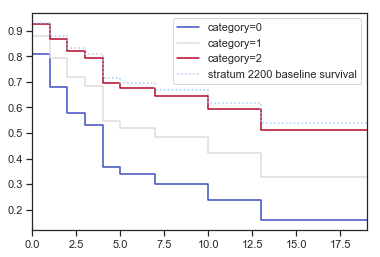

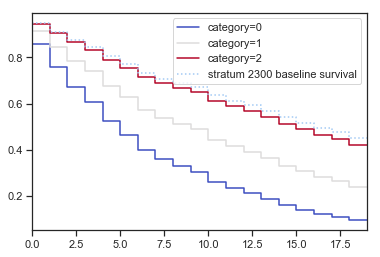

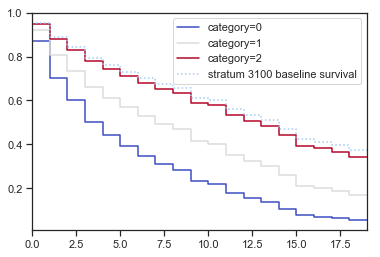

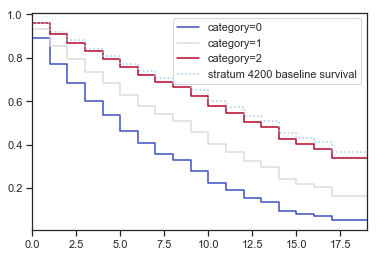

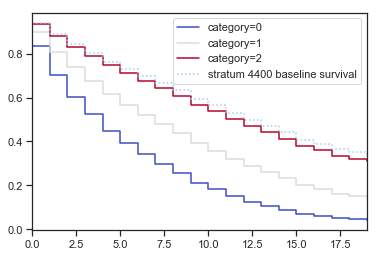

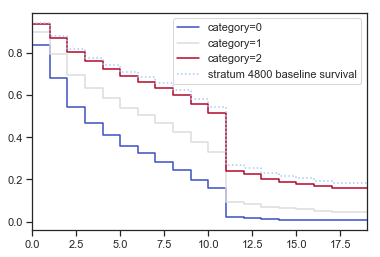

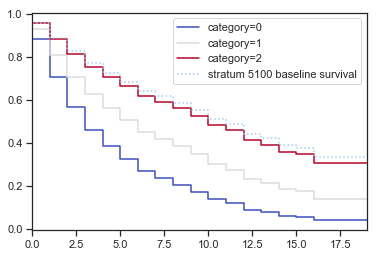

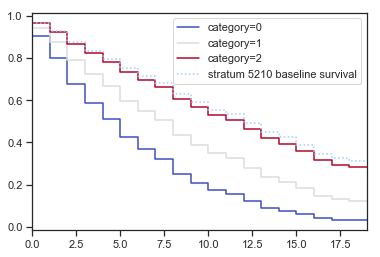

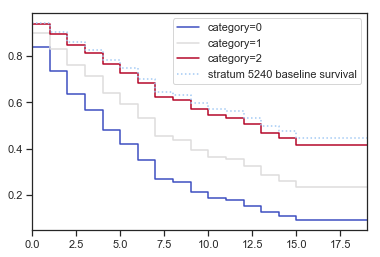

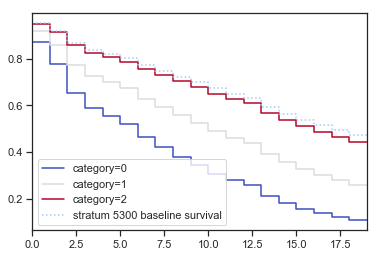

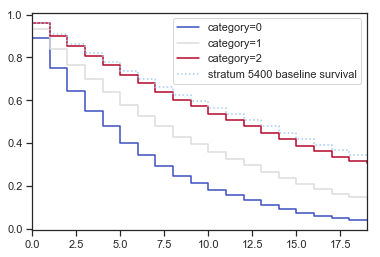

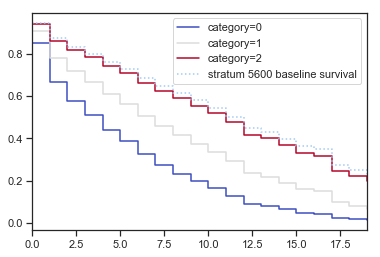

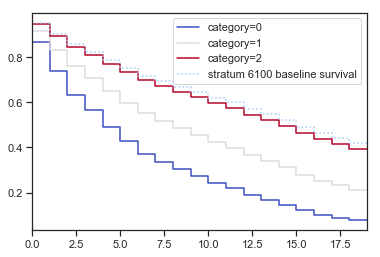

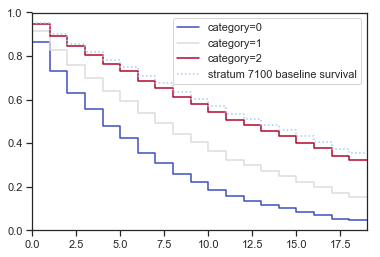

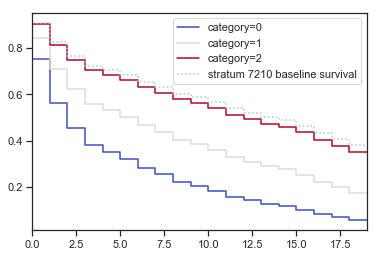

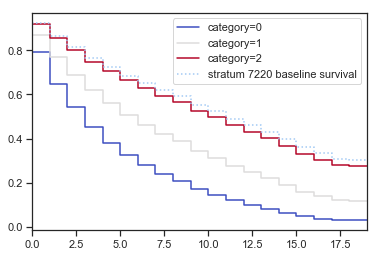

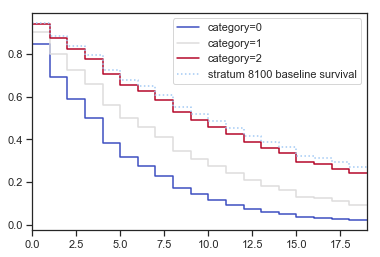

In [51]:
cph.plot_covariate_groups('category', values=np.arange(0, 3), cmap='coolwarm')

...and by businesses closed

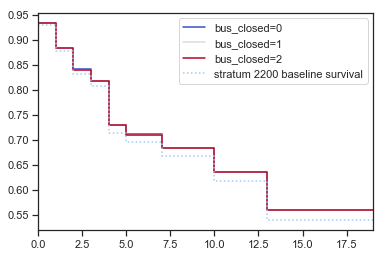

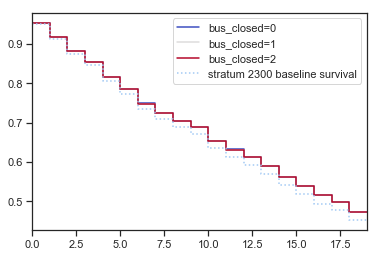

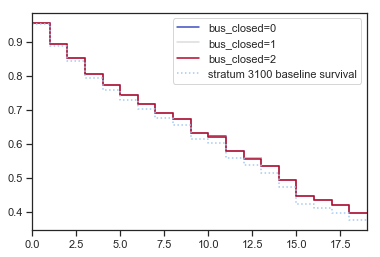

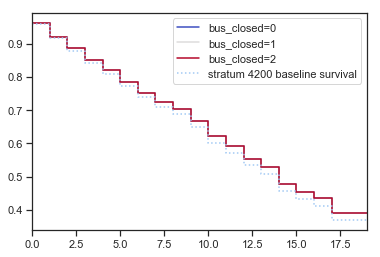

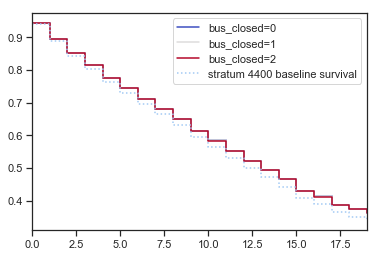

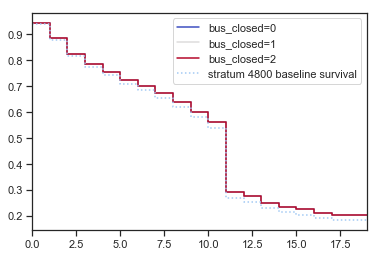

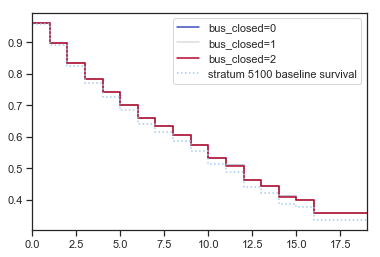

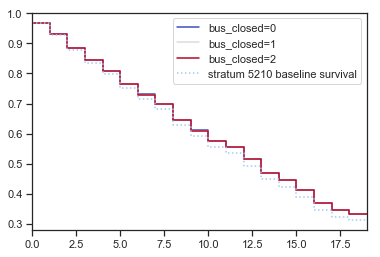

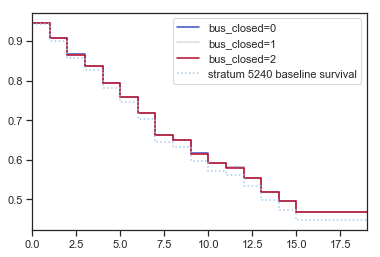

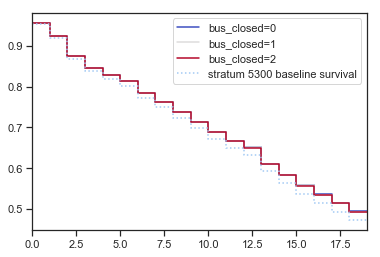

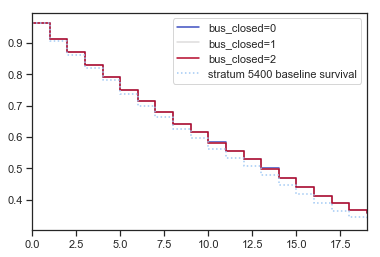

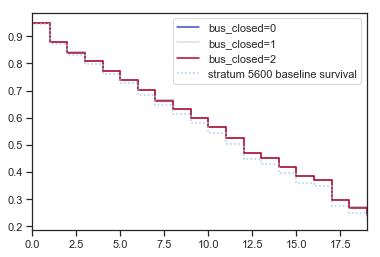

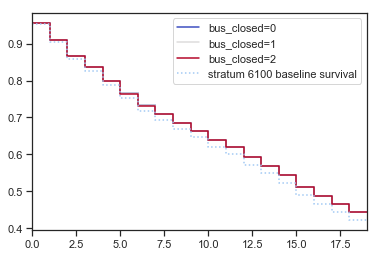

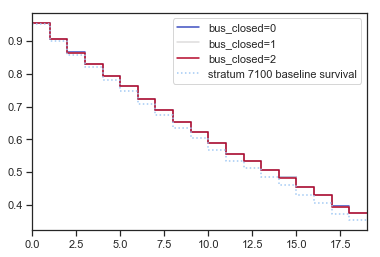

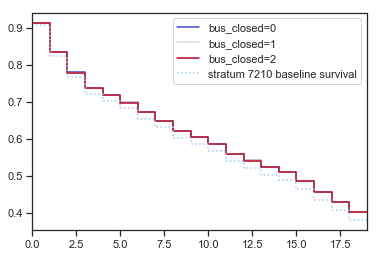

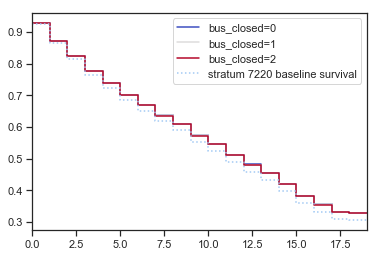

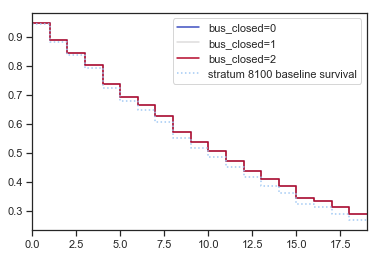

In [52]:
cph.plot_covariate_groups('bus_closed', values=np.arange(0, 3), cmap='coolwarm')

....for businesses opened

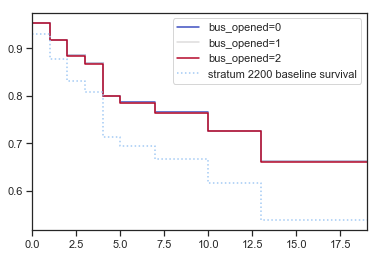

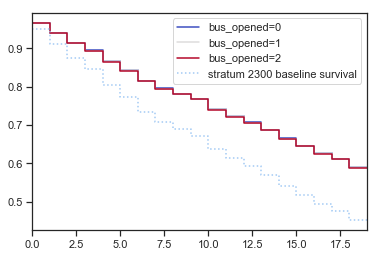

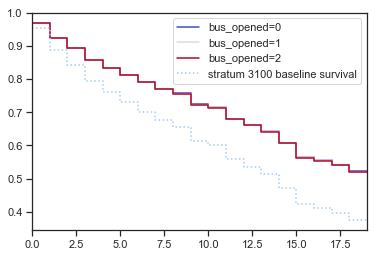

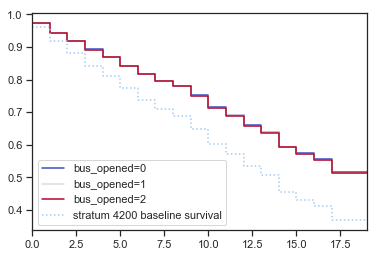

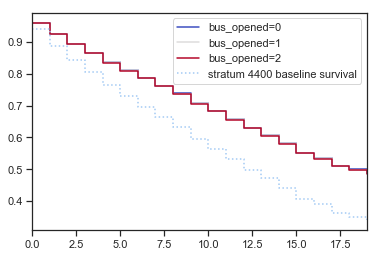

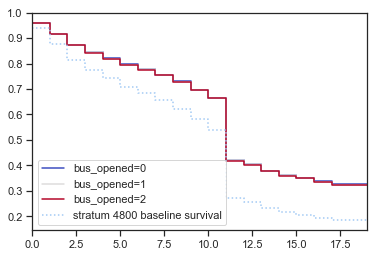

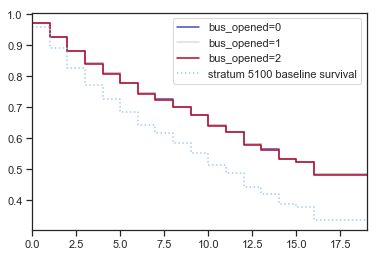

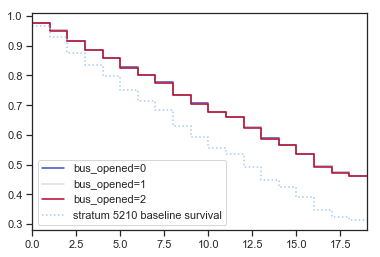

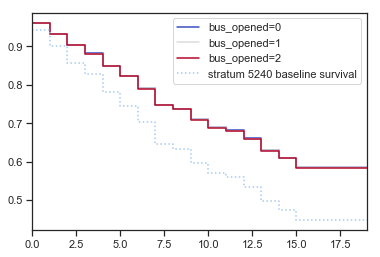

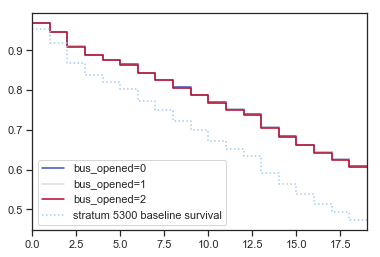

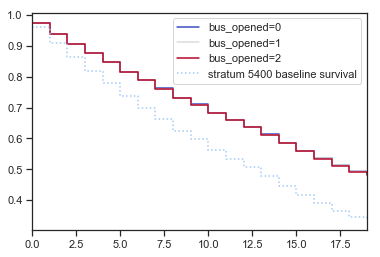

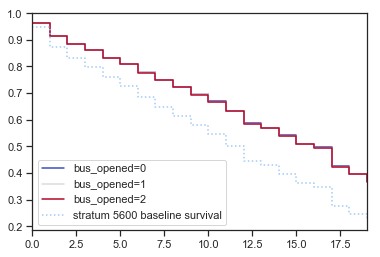

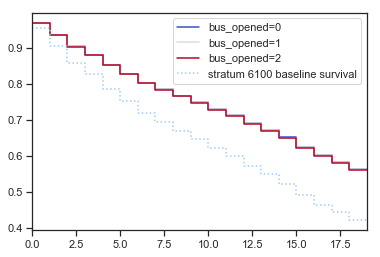

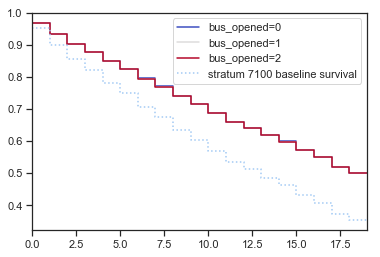

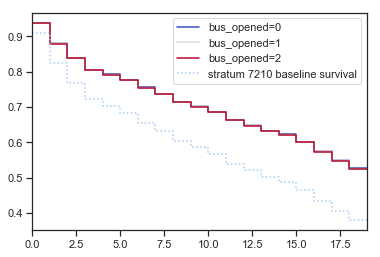

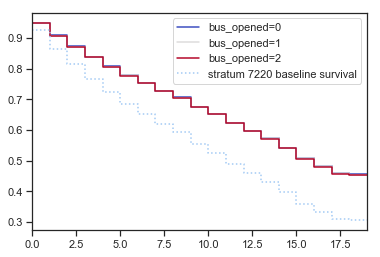

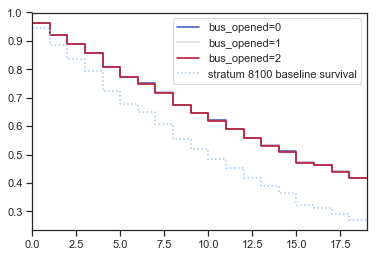

In [53]:
cph.plot_covariate_groups('bus_opened', values=np.arange(0, 3), cmap='coolwarm')

......for med value /sq ft

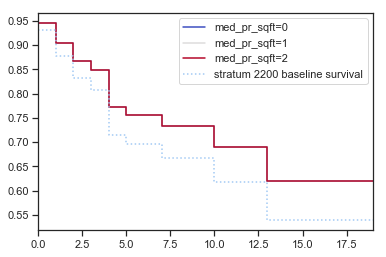

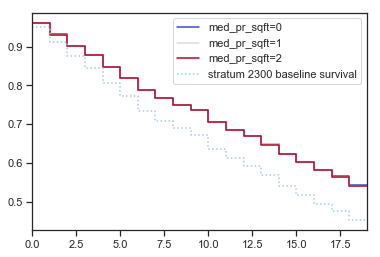

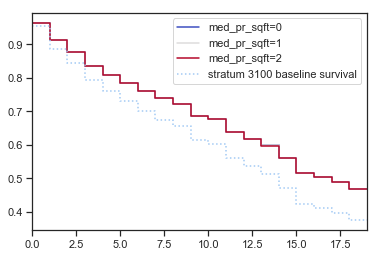

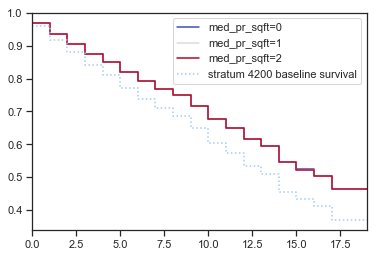

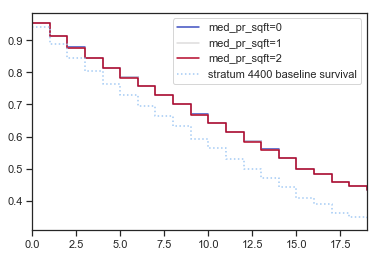

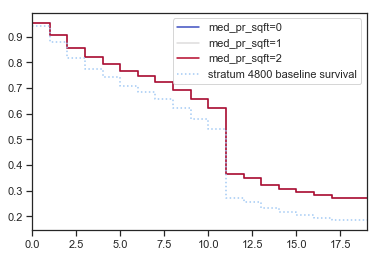

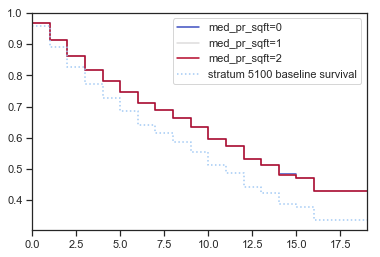

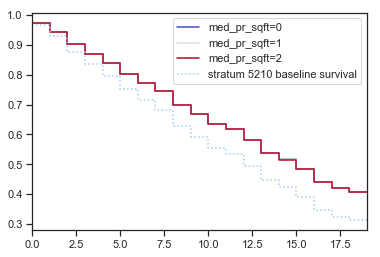

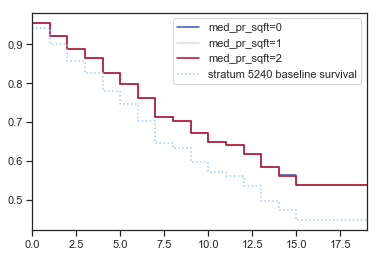

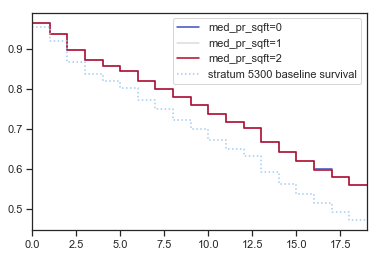

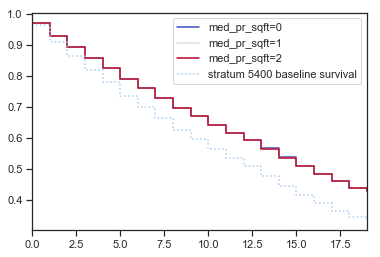

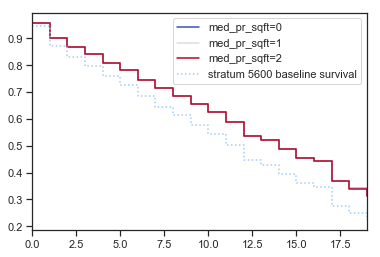

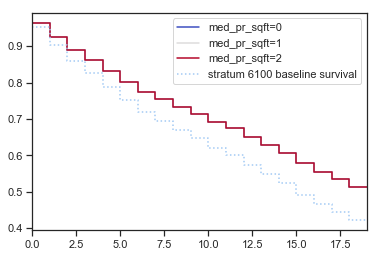

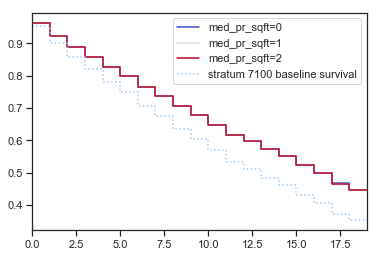

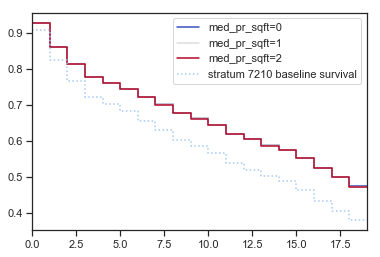

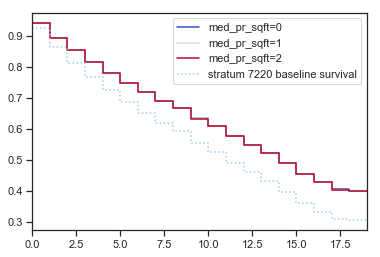

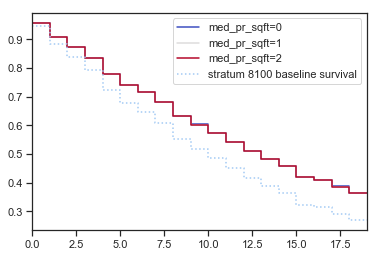

In [54]:
cph.plot_covariate_groups('med_pr_sqft', values=np.arange(0, 3), cmap='coolwarm')

.....let's compare it to variable that has no predictive value

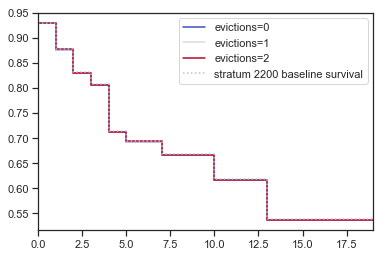

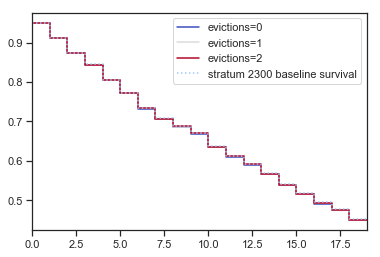

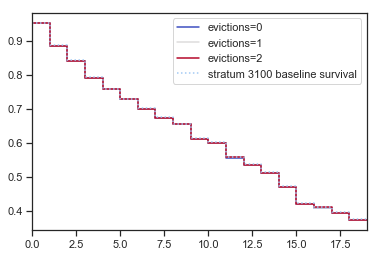

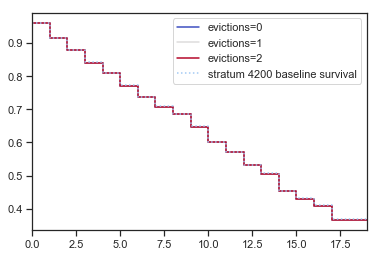

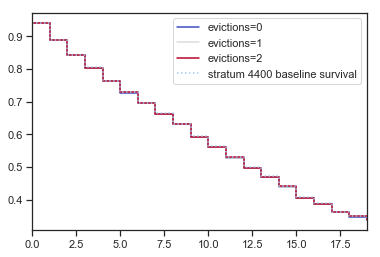

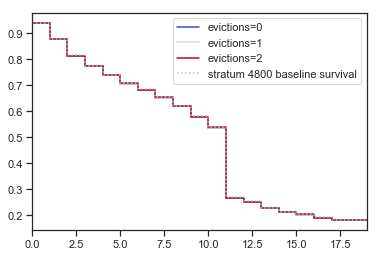

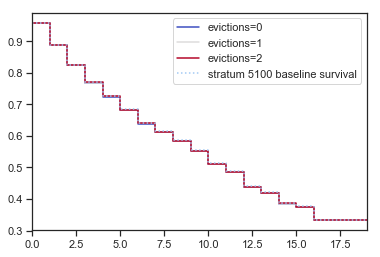

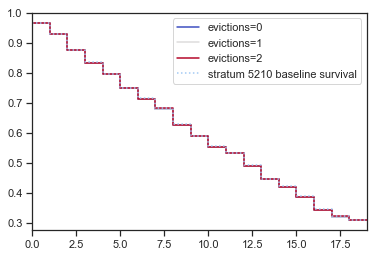

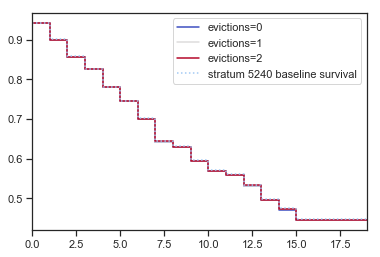

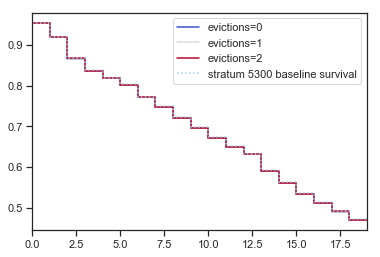

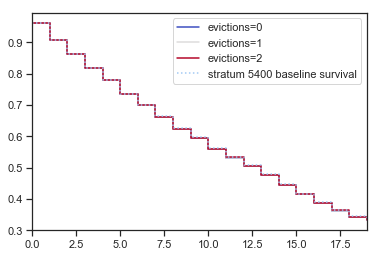

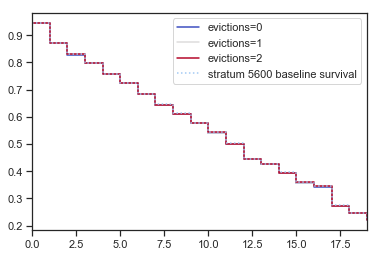

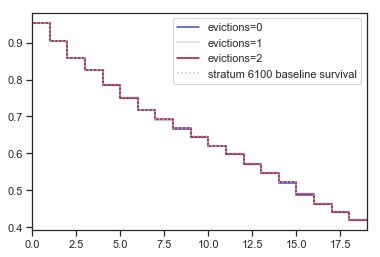

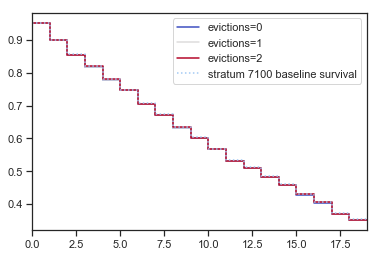

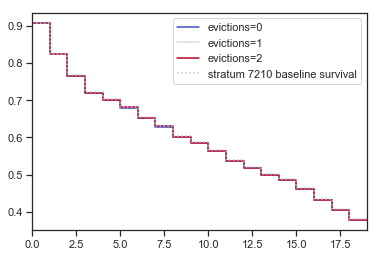

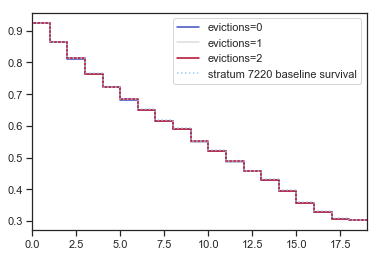

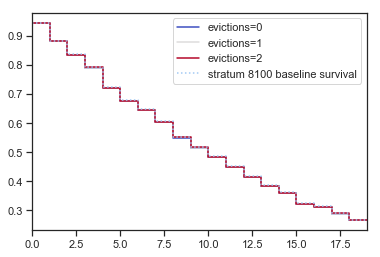

In [55]:
cph.plot_covariate_groups('evictions', values=np.arange(0, 3), cmap='coolwarm')

In [56]:
newdf.corr()

,lifetime,observed,category,size_rank,bus_opened,bus_closed,evictions,med_pr_sqft
lifetime,1.000000,-0.243570,-0.007012,-0.005425,-0.270272,-0.334152,-0.007756,-0.226792
observed,-0.243570,1.000000,0.032307,-0.002814,0.049695,-0.023081,-0.000514,-0.024631
category,-0.007012,0.032307,1.000000,-0.226727,0.744199,0.377413,0.281087,0.038755
size_rank,-0.005425,-0.002814,-0.226727,1.000000,-0.251226,-0.130740,-0.108474,0.510198
bus_opened,-0.270272,0.049695,0.744199,-0.251226,1.000000,0.490122,0.108922,-0.105722
bus_closed,-0.334152,-0.023081,0.377413,-0.130740,0.490122,1.000000,0.085559,0.016246
evictions,-0.007756,-0.000514,0.281087,-0.108474,0.108922,0.085559,1.000000,0.170713
med_pr_sqft,-0.226792,-0.024631,0.038755,0.510198,-0.105722,0.016246,0.170713,1.000000


Is there any difference when looking at this in quarters?

As we found in modeling the bus reg dataset, there doesn't seem to be much difference in results whether the duration is in years or quarters.

In [57]:
cph = CoxPHFitter()
cph.fit(newdf_qtrs, 'lifetime_qtrs', event_col='observed', strata='naic')
cph.print_summary(decimals=6)

<lifelines.CoxPHFitter: fitted with 103307 observations, 70827 censored>
      duration col = 'lifetime_qtrs'
         event col = 'observed'
            strata = naic
number of subjects = 103307
  number of events = 32480
    log-likelihood = -268887.904262
  time fit was run = 2019-05-19 01:44:58 UTC

---
                 coef exp(coef)  se(coef)          z        p   -log2(p)  lower 0.95  upper 0.95
category    -0.516660  0.596510  0.014961 -34.532933   <5e-07 865.660687   -0.545984   -0.487336
size_rank   -0.000049  0.999951  0.000005 -10.165581   <5e-07  78.228359   -0.000059   -0.000040
bus_opened   0.003154  1.003159  0.000063  50.128629   <5e-07        inf    0.003030    0.003277
bus_closed   0.000951  1.000952  0.000033  28.891521   <5e-07 607.303246    0.000887    0.001016
evictions   -0.000973  0.999028  0.000393  -2.471728 0.013446   6.216659   -0.001744   -0.000201
med_pr_sqft  0.000580  1.000580  0.000017  34.640977   <5e-07 871.056430    0.000547    0.000613
---
Concorda

There is a plot function associated with this model. In this case, because the values are small it does not look particularly interesting. Perhaps it can be tweaked. Something more to add to the next-steps list.

In [58]:
cph.score_

0.6370951538366346

In [59]:
cph.strata

'naic'

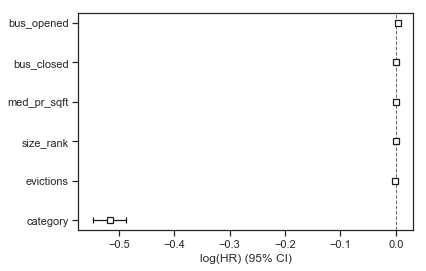

In [58]:
cph.plot()

Here we compute and plot residuals per the sample documentation, to compare with the results in notebook 3.1

In [61]:
########going forward only looking at newdf_qtrs

In [59]:
r = cph.compute_residuals(newdf_qtrs, 'martingale')
r.head()

,lifetime_qtrs,observed,martingale
76286,0.0,True,0.965110
94835,0.0,True,0.946764
96707,0.0,True,0.952949
96766,0.0,True,0.972602
109773,0.0,True,0.949829


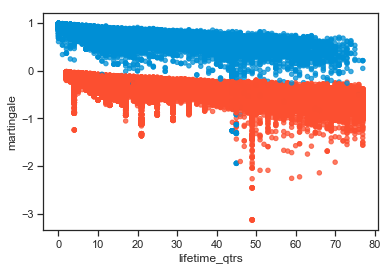

In [60]:
r.plot.scatter(
    x='lifetime_qtrs', y='martingale', c=np.where(r['observed'], '#008fd5', '#fc4f30'),
    alpha=0.75
);

From the Lifelines docs:  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Cox%20residuals.html

One problem with martingale residuals is that they are not symetric around 0. Deviance residuals are a transform of martingale residuals them symetric.

-  Roughly symmetric around zero, with approximate standard deviation equal to 1.
-  Positive values mean that the patient died sooner than expected.
-  Negative values mean that the patient lived longer than expected (or were censored).
-  Very large or small values are likely outliers.



In [61]:
r = cph.compute_residuals(newdf_qtrs, 'deviance')
r.head()

,lifetime_qtrs,observed,deviance
76286,0.0,True,2.186530
94835,0.0,True,1.993112
96707,0.0,True,2.051135
96766,0.0,True,2.291149
109773,0.0,True,2.021134


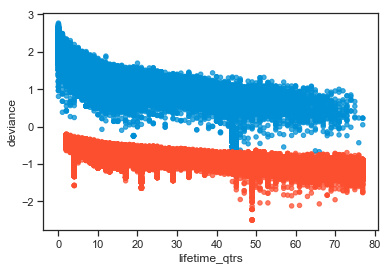

In [62]:
r.plot.scatter(
    x='lifetime_qtrs', y='deviance', c=np.where(r['observed'], '#008fd5', '#fc4f30'),
    alpha=0.75
);

In [63]:
r = r.join(newdf_qtrs.drop(['lifetime_qtrs', 'observed'], axis=1))

In [64]:
r.head()

,lifetime_qtrs,observed,deviance,category,size_rank,bus_opened,bus_closed,evictions,med_pr_sqft,naic
76286,0.0,True,2.186530,2,540,52,49,6,540,2200
94835,0.0,True,1.993112,2,892,63,50,2,1230,2200
96707,0.0,True,2.051135,2,355,109,59,23,742,2200
96766,0.0,True,2.291149,2,0,59,67,0,0,2200
109773,0.0,True,2.021134,2,355,106,51,14,867,2200


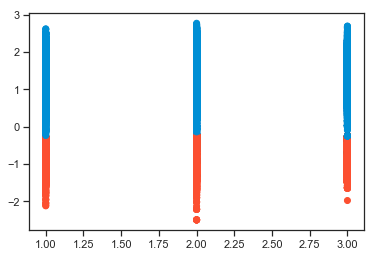

In [65]:
plt.scatter(r['category'], r['deviance'], color=np.where(r['observed'], '#008fd5', '#fc4f30'));

In [66]:
r = cph.compute_residuals(newdf_qtrs, 'delta_beta')
r.head()

,category,size_rank,bus_opened,bus_closed,evictions,med_pr_sqft
76286,0.025211,0.000005,-0.000109,-0.000054,0.000274,-0.000078
94835,0.014675,0.000004,-0.000032,-0.000058,-0.000053,-0.000010
96707,0.012669,-0.000005,-0.000062,-0.000059,0.000099,-0.000039
96766,0.028232,-0.000003,-0.000167,-0.000051,0.000379,-0.000115
109773,0.010454,-0.000007,-0.000051,-0.000062,-0.000016,-0.000023


In [67]:
r = r.join(newdf_qtrs[['lifetime_qtrs', 'observed']])
r.head()

,category,size_rank,bus_opened,bus_closed,evictions,med_pr_sqft,lifetime_qtrs,observed
76286,0.025211,0.000005,-0.000109,-0.000054,0.000274,-0.000078,0,1
94835,0.014675,0.000004,-0.000032,-0.000058,-0.000053,-0.000010,0,1
96707,0.012669,-0.000005,-0.000062,-0.000059,0.000099,-0.000039,0,1
96766,0.028232,-0.000003,-0.000167,-0.000051,0.000379,-0.000115,0,1
109773,0.010454,-0.000007,-0.000051,-0.000062,-0.000016,-0.000023,0,1


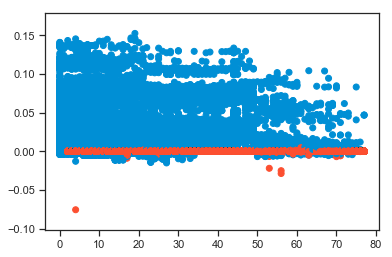

In [68]:
plt.scatter(r['lifetime_qtrs'], r['category'], color=np.where(r['observed'], '#008fd5', '#fc4f30'));

In [69]:
#cph = CoxPHFitter().fit(newdf_qtrs, 'T', 'E')
censored_subjects = newdf_qtrs.loc[newdf_qtrs['observed'] == 0]
unconditioned_sf = cph.predict_survival_function(censored_subjects)

conditioned_sf = unconditioned_sf.apply(lambda c: (c / c.loc[newdf_qtrs.loc[c.name, 'lifetime_qtrs']]).clip_upper(1))

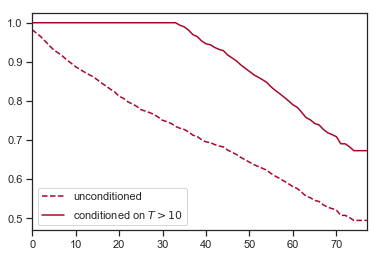

In [70]:
# let's focus on a single subject
subject = 13
unconditioned_sf[subject].plot(ls="--", color="#A60628", label="unconditioned")
conditioned_sf[subject].plot(color="#A60628", label="conditioned on $T>10$")
plt.legend();

<h3>Conclusions and Next Steps

Applying survival analysis has shown that there is a relationship between the lifetime of a business and the neighborhood it is in, and that there are certain changing characteristics about neighborhoods that do have predictive value when estimating business lifetimes.

We looked used two survival analysis approaches on two datasets to reach the following conclusions. 


***Kaplan-Meier - Estimating survival rates for specific populations***

We plotted the survival curve for businesses from the registered businesses dataset for all of SF and spedific neighborhoods, selected to represent both non-gentrifying and gentrifying census tracts (reference: https://www.urbandisplacement.org/map/sf), and used Statistic logrank_test to show that there is a statistical difference between various neighborhoods.

We used the Cox Proportional Hazards Model to perform survival regression on the the registered businesses dataset and the, neighborhood by quarters dataset, which combined features from the business data and other resource. In both cases we found features with predictive value. 

With the survival regression, when determining whether certain variable can be predictors of the desired outcome, we first define a null hypothesis that states that ***there is no evidence that the data we observe could not happen by chance.*** We also define a threshold (alpha) probability beyond which we will conclude that it is not-likely to observe these results by chance. We measure this with a p-value. 

For this project we used an alpha of .005 (a standard to use when there is no domain specific reason to use a different value. In each model we observed variables with p-values way below the threshold, meaning it is very unlikely we would observe this data by chance. we therefore reject the null hypothesis and conclude that there is predictive value for the following variables. 

These values were present in, exhibited predictive value (p-value < 0.005) in, both datasets:

| Feature  | Description |
|---------|-----------------------------------------------------------------------
| category    | neighborhood designated as sparse, medium, dense by number of records in the original dataset |
| rank  | neighborhood sized as ranked by Zillow  


These values were only in the neighborhood by quarter dataset, and exhibit similar predictive value (p-value < 0.005) both when using a duration of years and of quarters:



| Feature  | Description |
|---------|-----------------------------------------------------------------------
| bus_opened | number of businesses that opened in the same neighborhood during the start quarter  |
| bus_closed  | number of businesses that closed in the same neighborhood during the start quarter | 
| med_price_sqft | median home value per sqft for the neighborhood for the start quarter |


One variable did not exhibit predictive power (p-value .27):

| Feature  | Description |
|---------|-----------------------------------------------------------------------|
| evictions | Number of eviction notices filed in the same neighborhood during the same quarter |

<br>
The p-values for both category and size_rank were well below the threshold, which means they have predictive value. In this case however, the coefficients are both negative, whereas when used with the registered business dataset they were positive. This raises questions for further exploration, but indicates that the expected life of a business, all other things being equal, is at least in part influenced by the size of the neighborhood, in terms of density of businesses.

Let's look at the new features added for this model. Given the p-value for evictions (.27) is well above the threshold of .005 we cannot say that knowing the rate of evictions for a neighborhood has any predictive power or estimating the lifetime of a business.

The other added features, number of businesses opened, number of businesses closed, and median price per square feet all do have predictive value. Note that both businesses opened and business closed are positively correlated with the the event (business closing.) It is reasonable, I suppose, that it may be harder to keep a business going in neighborhoods with more turnover. 

We also see that as the average median value per square foot increases, the length of survival of a business decreases (because the hazard ration for the business closing increases.)

Concordance is a measure of how predictive censored data is. It is similar to the to area under an ROC curve. Notice it is higher here than what we observed on the larger dataset where fewer variables were taken into consideration.  <br><br>

***How does this help us better understand gentrification?***<br><br>
It answers the question we set out to solve: yes, neighborhood characteristics can be predictive of business lifetimes. <br><br>Seen in the bigger picture, this could be expanded to include many more feature, and the features themselves could be studied and refined. Business owners could use this information to make decisions about where to open, or how to factor lifetime predictions into their business plans and look for ways to combat the natural tendencies. Information of this nature could be fed to other models to help city planners with strategic decision making. This only scratches the surface but suggests that much more could be discovered by continuing this line of inquiry. 